# Project idea : 
**Help young adults to take care of administrative documents necessary for them**
1. set the requirements
2. explore the tools necessary for the project & put them in a utils file
3. set a .env with API keys


In [ ]:
# %pip install r- ./requirements.txt 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: 'r-': Expected end or semicolon (after name and no valid version specifier)
    r-
     ^


In [12]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
if os.path.exists(".env"):
    load_dotenv()
    print("Environment variables loaded from .env file.")


# Access the API key
api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    print("API Key loaded successfully!")
else:
    print("API Key not found. Please check your .env file.")

Environment variables loaded from .env file.
API Key loaded successfully!


** This project consists of creating an agent that will help young adults through administrative documents: **
- The agent will be able to upload the document
- It will read it and answer related questions
- 

In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [ ]:
# define our client 
llm_client = ChatOpenAI (model_name = "gpt-5", temperature= 0.0)

In [ ]:
import re
import io
import requests
from langchain_core.tools import tool
from typing import Annotated, Sequence, TypedDict, Optional
from typing import Annotated, Optional
import shutil
from pathlib import Path

In [ ]:
# Create a path where the doc will be loaded from 
UPLOAD_DIRECTORY = Path("./Project_Agentic/") / "uploads"
UPLOAD_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [ ]:
#define the functions

#1. Function that can read a document
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (UPLOAD_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

#2. Function that can upload a document
@tool
def upload_document(
    source_path: Annotated[str, "Local file path to upload."],
    destination_name: Annotated[Optional[str], "Name to save the file as."] = None,
) -> str:
    """Upload a document into the working directory."""
    destination_name = destination_name or source_path.split("/")[-1]
    destination_path = UPLOAD_DIRECTORY / destination_name
    shutil.copy(source_path, destination_path)
    return f"File uploaded successfully as {destination_name}"

#3. Function that can write a response according the the document 
@tool
def answer_from_document(user_message: str, file_name: str) -> str:
    """
    Answer a human message using the content of the uploaded document.
    """
    document_content = read_document(file_name)

    messages = [
        {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided document."},
        {"role": "user", "content": f"Document content:\n{document_content}"},
        {"role": "user", "content": f"Question: {user_message}"}
    ]
    
    # Call GPT
    response = client.chat.completions.create(
        model="gpt-5",
        messages=messages,
        temperature=0 
    )
    answer = response.choices[0].message["content"]
    return answer

def print_response_details(resp):
    import json

    # flatten various container shapes
    if isinstance(resp, dict):
        items = []
        for v in resp.values():
            if isinstance(v, list):
                items.extend(v)
            else:
                items.append(v)
    elif isinstance(resp, list):
        items = resp
    else:
        # fallback: try common attributes
        items = getattr(resp, "messages", getattr(resp, "generations", [resp]))

    for m in items:
        # dict-like message
        if isinstance(m, dict):
            content = m.get("content") or m.get("text") or ""
            print(f"DictMessage: {content}")
            if "tool_calls" in m:
                print("  tool_calls:", json.dumps(m["tool_calls"], indent=2))
            print("---")
            continue

        cls = m.__class__.__name__
        content = getattr(m, "content", None)
        print(f"{cls}: {content}")

        # ToolMessage specifics
        name = getattr(m, "name", None)
        if name:
            print(f"  tool name: {name}")

        # common places LangChain stores tool call info
        tool_calls = getattr(m, "tool_calls", None) or getattr(m, "tool_call", None)
        if tool_calls:
            print("  tool_calls:")
            try:
                print(json.dumps(tool_calls, default=str, indent=2))
            except Exception:
                print("   ", tool_calls)

        # some Versions put tool call info in response_metadata or additional_kwargs
        meta = getattr(m, "response_metadata", None) or getattr(m, "additional_kwargs", None)
        if isinstance(meta, dict):
            if "tool_calls" in meta:
                print("  response_metadata.tool_calls:", json.dumps(meta["tool_calls"], indent=2))
            if "finish_reason" in meta:
                print("  finish_reason:", meta["finish_reason"])

        print("---")

In [18]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict): #1 define state 
    messages: Annotated[Sequence[BaseMessage], add_messages]
    system_prompt: SystemMessage

In [24]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

# tool node
def tool_node(state: AgentState) -> AgentState:
    outputs = []
    for tool_call in state["messages"][-1].tool_calls: #tool_call exists so loop is necessary
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],

            )
        )
    return {"messages": outputs}

# node that calls the llm model // State evolves while going from a node to another 
def call_llm_node(state: AgentState,
                  config: RunnableConfig) -> AgentState:

    response = llm_model_with_tools.invoke([state["system_prompt"]] + state["messages"], config=config) #node makes call to llm
    # We return a list, because this will get added to the exisitng list of messages
    return {"messages": [response]}

# if loop : condition edge that determines whether to continue or not
def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else: 
        return "continue"

In [ ]:
from langgraph.graph import StateGraph, START, END

# Graph
workflow = StateGraph(AgentState) 

# Define the two nodes we will cycle between
workflow.add_node("agent", call_llm_node)  #llm
workflow.add_node("tool", tool_node)   #tool

workflow.add_edge(START, "agent")

# loop
workflow.add_conditional_edges(  
    "agent", 
    
    should_continue,
    {
        # If `tools`, then call the tool node.
        "continue": "tool", 
        # Otherwise finish.
        "end": END,
        },
    )
# Finally, we need to add an edge from tool back to agent
workflow.add_edge("tool", "agent")

graph = workflow.compile()

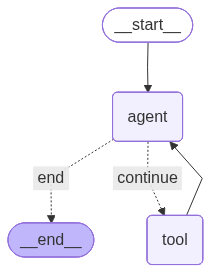

In [26]:
display(graph)

In [ ]:
# We will use stream to get detailed steps to the answer